# Get the vibe - Experimental Notebook

## Set up

### Imports

In [1]:
# General libraries
import numpy as np
import pandas as pd

# Image related
import matplotlib.pyplot as plt 
from matplotlib import image
from keras.preprocessing.image import load_img, img_to_array
import os

# CNN
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import Sequential, layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

# Confusion Matrix & Additional Metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# Google Colab
from google.colab import drive 

#### Set up

##### Google Drive Imports 

In [2]:
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
image_df = pd.read_csv("/content/drive/MyDrive/fer2013.csv")

##### Imports

In [4]:
# Import Data 
#image_df = pd.read_csv("../raw_data/fer2013.csv")

In [5]:
# Data Path
# folder_path = "../../JaildoR/getthevibe_api/getthevibe_api/data/fer2013.csv"

In [6]:
# Define Emotions
Emotions = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]  # indices 0 to 6

In [7]:
# Insert column emotions
image_df["emotion_new"] = image_df["emotion"].map({0: "Angry", 1: "Disgust", 2: "Fear", 3: "Happy", 4: "Sad", 5: "Surprise", 6: "Neutral"})

In [8]:
# Define formate
FER2013_WIDTH = 48
FER2013_HEIGHT = 48

## Preprosessing

### Exclude "disgust"

In [9]:
#image_df = image_df[image_df.emotion != 1]

### Training Data Split

In [10]:
train_set = image_df[(image_df.Usage == 'Training')] 
val_set = image_df[(image_df.Usage == 'PublicTest')]
test_set = image_df[(image_df.Usage == 'PrivateTest')] 

### Reshape X

In [11]:
# define x
X_train = np.array(list(map(str.split, train_set.pixels)), np.float32) 
X_val = np.array(list(map(str.split, val_set.pixels)), np.float32) 
X_test = np.array(list(map(str.split, test_set.pixels)), np.float32) 


X_train = X_train.reshape(X_train.shape[0], 48, 48, 1) 
X_val = X_val.reshape(X_val.shape[0], 48, 48, 1)
X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)

### Scaling 

In [12]:
X_train = (X_train/255) -0.5
X_val = (X_val/255) - 0.5
X_test = (X_test/255) - 0.5

### One hot encode y

In [13]:
# define y
y_train = train_set["emotion"]
y_val = val_set["emotion"]
y_test = test_set["emotion"]

In [14]:
y_test

32298    0
32299    5
32300    6
32301    4
32302    2
        ..
35882    6
35883    3
35884    0
35885    3
35886    2
Name: emotion, Length: 3589, dtype: int64

In [15]:
# One Hot Encode our Target for TensorFlow processing
from tensorflow.keras.utils import to_categorical

y_cat_train = to_categorical(y_train, num_classes=7)
y_cat_test = to_categorical(y_test, num_classes=7)
y_cat_val = to_categorical(y_val, num_classes=7)

## General Evaluation Functions

In [16]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    ax2.set_title('Accurary')
    ax2.legend()
    return (ax1, ax2)

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
"""
Displays a confusion matrix 
"""

def confusio(X_test, y_test, model):
    
    predicted_probabilities = model.predict(X_test)
    def prediction_from_probabilities(predicted_probabilities):
        return np.argmax(predicted_probabilities)
    y_pred = np.apply_along_axis(prediction_from_probabilities, 
                                 1,                            
                                 predicted_probabilities)
    
    
    labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'] # adapted to without "digust"
    cm = confusion_matrix(y_test, y_pred)
    cm = cm / cm.astype(np.float).sum(axis=1) # convert into percentages
    
    
    disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                              display_labels = labels);
    fig, ax = plt.subplots(figsize=(10,10));
    title='Confusion matrix'
    plt.title(title)
    disp.plot(cmap = "PuRd", ax = ax);
    pass

##  Model

### Cheeta model

#### Cheeta  model

In [18]:
# Define regularizer
reg_l12 = regularizers.L1L2(l1=0.001, l2=0.001)

In [51]:
### 1. Architecture
model_insane = models.Sequential()

model_insane.add(layers.Conv2D(16, (6, 6), 
                 padding='same',
                 strides = (1,1),
                 input_shape=(48, 48, 1),
                 activation='relu'))

model_insane.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_insane.add(layers.Dropout(0.2))

model_insane.add(layers.Conv2D(32, (5, 5), padding='same', activation='relu'))
model_insane.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_insane.add(layers.Dropout(0.2))

model_insane.add(layers.Conv2D(64, (4, 4), padding='same', activation='relu'))
model_insane.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_insane.add(layers.Dropout(0.2))

model_insane.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model_insane.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_insane.add(layers.Dropout(0.2))

model_insane.add(layers.Flatten())
model_insane.add(layers.Dense(500, activation='relu'))
model_insane.add(layers.Dropout(0.3))
model_insane.add(layers.Dense(7, activation='softmax'))

model_insane.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_44 (Conv2D)          (None, 48, 48, 16)        592       
                                                                 
 max_pooling2d_44 (MaxPoolin  (None, 24, 24, 16)       0         
 g2D)                                                            
                                                                 
 dropout_47 (Dropout)        (None, 24, 24, 16)        0         
                                                                 
 conv2d_45 (Conv2D)          (None, 24, 24, 32)        12832     
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 12, 12, 32)       0         
 g2D)                                                            
                                                                 
 dropout_48 (Dropout)        (None, 12, 12, 32)       

In [52]:
#### 2. Compilation

model_insane.compile(loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

In [53]:
#### 3. Fit
es = EarlyStopping(patience=15, restore_best_weights=True,)

history = model_insane.fit(X_train, y_cat_train,
                    epochs=150,
                    batch_size=32, 
                    verbose=1,
                    use_multiprocessing = True,
                    validation_data=(X_val,y_cat_val),
                    callbacks=[es]) 

Epoch 1/150
898/898 [==============================] - 11s 12ms/step - loss: 1.6720 - accuracy: 0.3271 - val_loss: 1.4493 - val_accuracy: 0.4439
Epoch 2/150
898/898 [==============================] - 10s 11ms/step - loss: 1.4396 - accuracy: 0.4395 - val_loss: 1.3239 - val_accuracy: 0.4904
Epoch 3/150
898/898 [==============================] - 10s 11ms/step - loss: 1.3375 - accuracy: 0.4833 - val_loss: 1.2683 - val_accuracy: 0.5113
Epoch 4/150
898/898 [==============================] - 10s 11ms/step - loss: 1.2803 - accuracy: 0.5138 - val_loss: 1.2140 - val_accuracy: 0.5341
Epoch 5/150
898/898 [==============================] - 9s 11ms/step - loss: 1.2391 - accuracy: 0.5239 - val_loss: 1.2113 - val_accuracy: 0.5369
Epoch 6/150
898/898 [==============================] - 10s 11ms/step - loss: 1.2019 - accuracy: 0.5432 - val_loss: 1.1823 - val_accuracy: 0.5517
Epoch 7/150
898/898 [==============================] - 10s 11ms/step - loss: 1.1781 - accuracy: 0.5489 - val_loss: 1.1710 - val_acc

In [43]:
# Safe model
import joblib
joblib.dump(model_insane, '../model_insane.joblib')

KeyboardInterrupt: ignored

Exception ignored in: 'zmq.backend.cython.message.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq/backend/cython/checkrc.pxd", line 13, in zmq.backend.cython.checkrc._check_rc
KeyboardInterrupt


INFO:tensorflow:Assets written to: ram://33654883-4d1e-4353-acca-fb0c4934a371/assets


['../model_insane.joblib']

#### Evaluation

In [57]:
# Evaluate model on the test data
print(model_insane.evaluate(X_test, y_cat_test, verbose=0))

[1.0746917724609375, 0.606854259967804]


(<matplotlib.axes._subplots.AxesSubplot at 0x7f88b1373c90>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f88b1590910>)

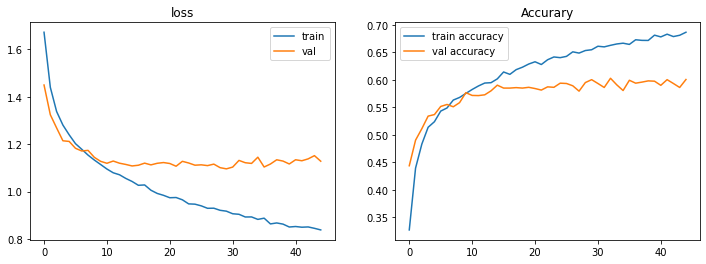

In [56]:
plot_history(history)

In [28]:
from sklearn.metrics import classification_report

labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
predicted_probabilities = model_insane.predict(X_test)
def prediction_from_probabilities(predicted_probabilities):
    return np.argmax(predicted_probabilities)
y_pred = np.apply_along_axis(prediction_from_probabilities, 
                             1,                            
                             predicted_probabilities)

print(classification_report(y_test, y_pred, target_names=labels))

              precision    recall  f1-score   support

       Angry       0.55      0.45      0.49       491
     Disgust       0.72      0.42      0.53        55
        Fear       0.54      0.24      0.33       528
       Happy       0.73      0.87      0.80       879
         Sad       0.41      0.52      0.46       594
    Surprise       0.69      0.75      0.72       416
     Neutral       0.55      0.58      0.56       626

    accuracy                           0.59      3589
   macro avg       0.60      0.55      0.55      3589
weighted avg       0.59      0.59      0.58      3589



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


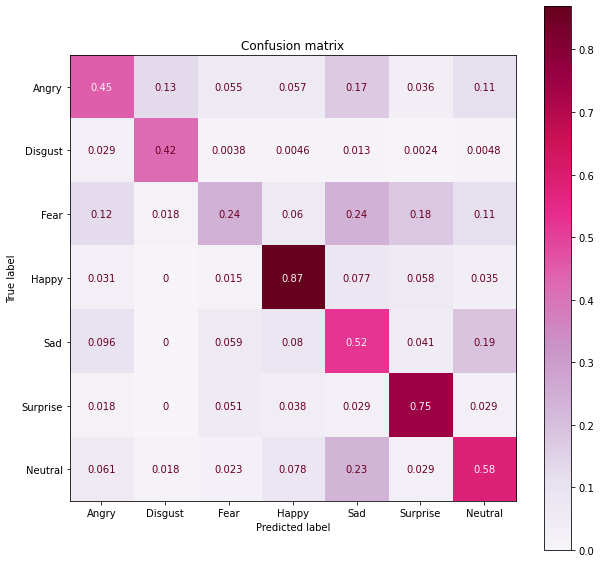

In [29]:
confusio(X_test, y_test, model_insane)